In [74]:
import json
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

In [75]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [76]:
def merge_images_horizontally(img1, img2):
    # 合并两个图像为一个水平图像
    dst = Image.new('RGB', (img1.width + img2.width, img1.height))
    dst.paste(img1, (0, 0))
    dst.paste(img2, (img1.width, 0))
    return dst

In [77]:
def create_image_grid(images):
    # 创建一个图像网格
    grid_size = int(np.ceil(np.sqrt(len(images))))
    grid_img = Image.new('RGB', (images[0].width * grid_size, images[0].height * grid_size))
    for i, img in enumerate(images):
        grid_img.paste(img, ((i % grid_size) * img.width, (i // grid_size) * img.height))
    return grid_img

In [78]:
def process_index(all_files, all_angles, path_caption_data, path_data_pc, path_data_rgb, index=None):
    if index is None:
        index = np.random.randint(len(all_files))
        
    name = all_files[index]
    pc_np = np.load(os.path.join(path_data_pc, name + ".npy"))
    print("pc_np.shape: ")
    print(pc_np.shape)
    
    data = {'pointcloud_np': pc_np}
    
    captions_data = load_json(os.path.join(path_caption_data, name + ".json"))
    
    caption_missing = 0
    
    RGB_imgs = []
    for i, angle in enumerate(all_angles):
        img_name = name + f"_r_{angle:03d}.png"
        
        img_path = os.path.join(path_data_rgb, img_name)
        
        if img_name in captions_data:
            captions_rgb = captions_data[img_name]
        else:
            captions_rgb = [""] * 10  # 如果找不到对应的描述，使用空描述
            caption_missing += 1
            
        img_a = Image.open(img_path)
        
        RGB_imgs.append(img_a)
        
        data[f'angle_{i+1}'] = {
            'angle': angle,
            'image': img_a,
            'captions': captions_rgb,
        }
    
    if caption_missing > 0:
        print("!!!" + str(caption_missing) + " captions are missing!!!")
    
    RGB_imgs_show = create_image_grid(RGB_imgs)
        
    return data, RGB_imgs_show

In [79]:
dataset_path = "/mnt/disk2/iLori/ShapeNet-55-ULIP-2-triplets/"
path_caption_data = os.path.join(dataset_path, 'captions')
path_data_pc = os.path.join(dataset_path, "shapenet_pc")
path_data_rgb = os.path.join(dataset_path, "only_rgb_depth_images")

In [80]:
all_angles = np.arange(0, 360, 12)
print(len(all_angles))

30


In [81]:
keyword = "plane"

In [82]:
json_file = os.path.join(dataset_path, "filter_by_keyword", keyword + ".json")
plane_list = load_json(json_file)
print(len(plane_list))

2860


In [83]:
data, RGB_imgs_show = process_index(plane_list, all_angles, path_caption_data, path_data_pc, path_data_rgb)


pc_np.shape: 
(8192, 3)


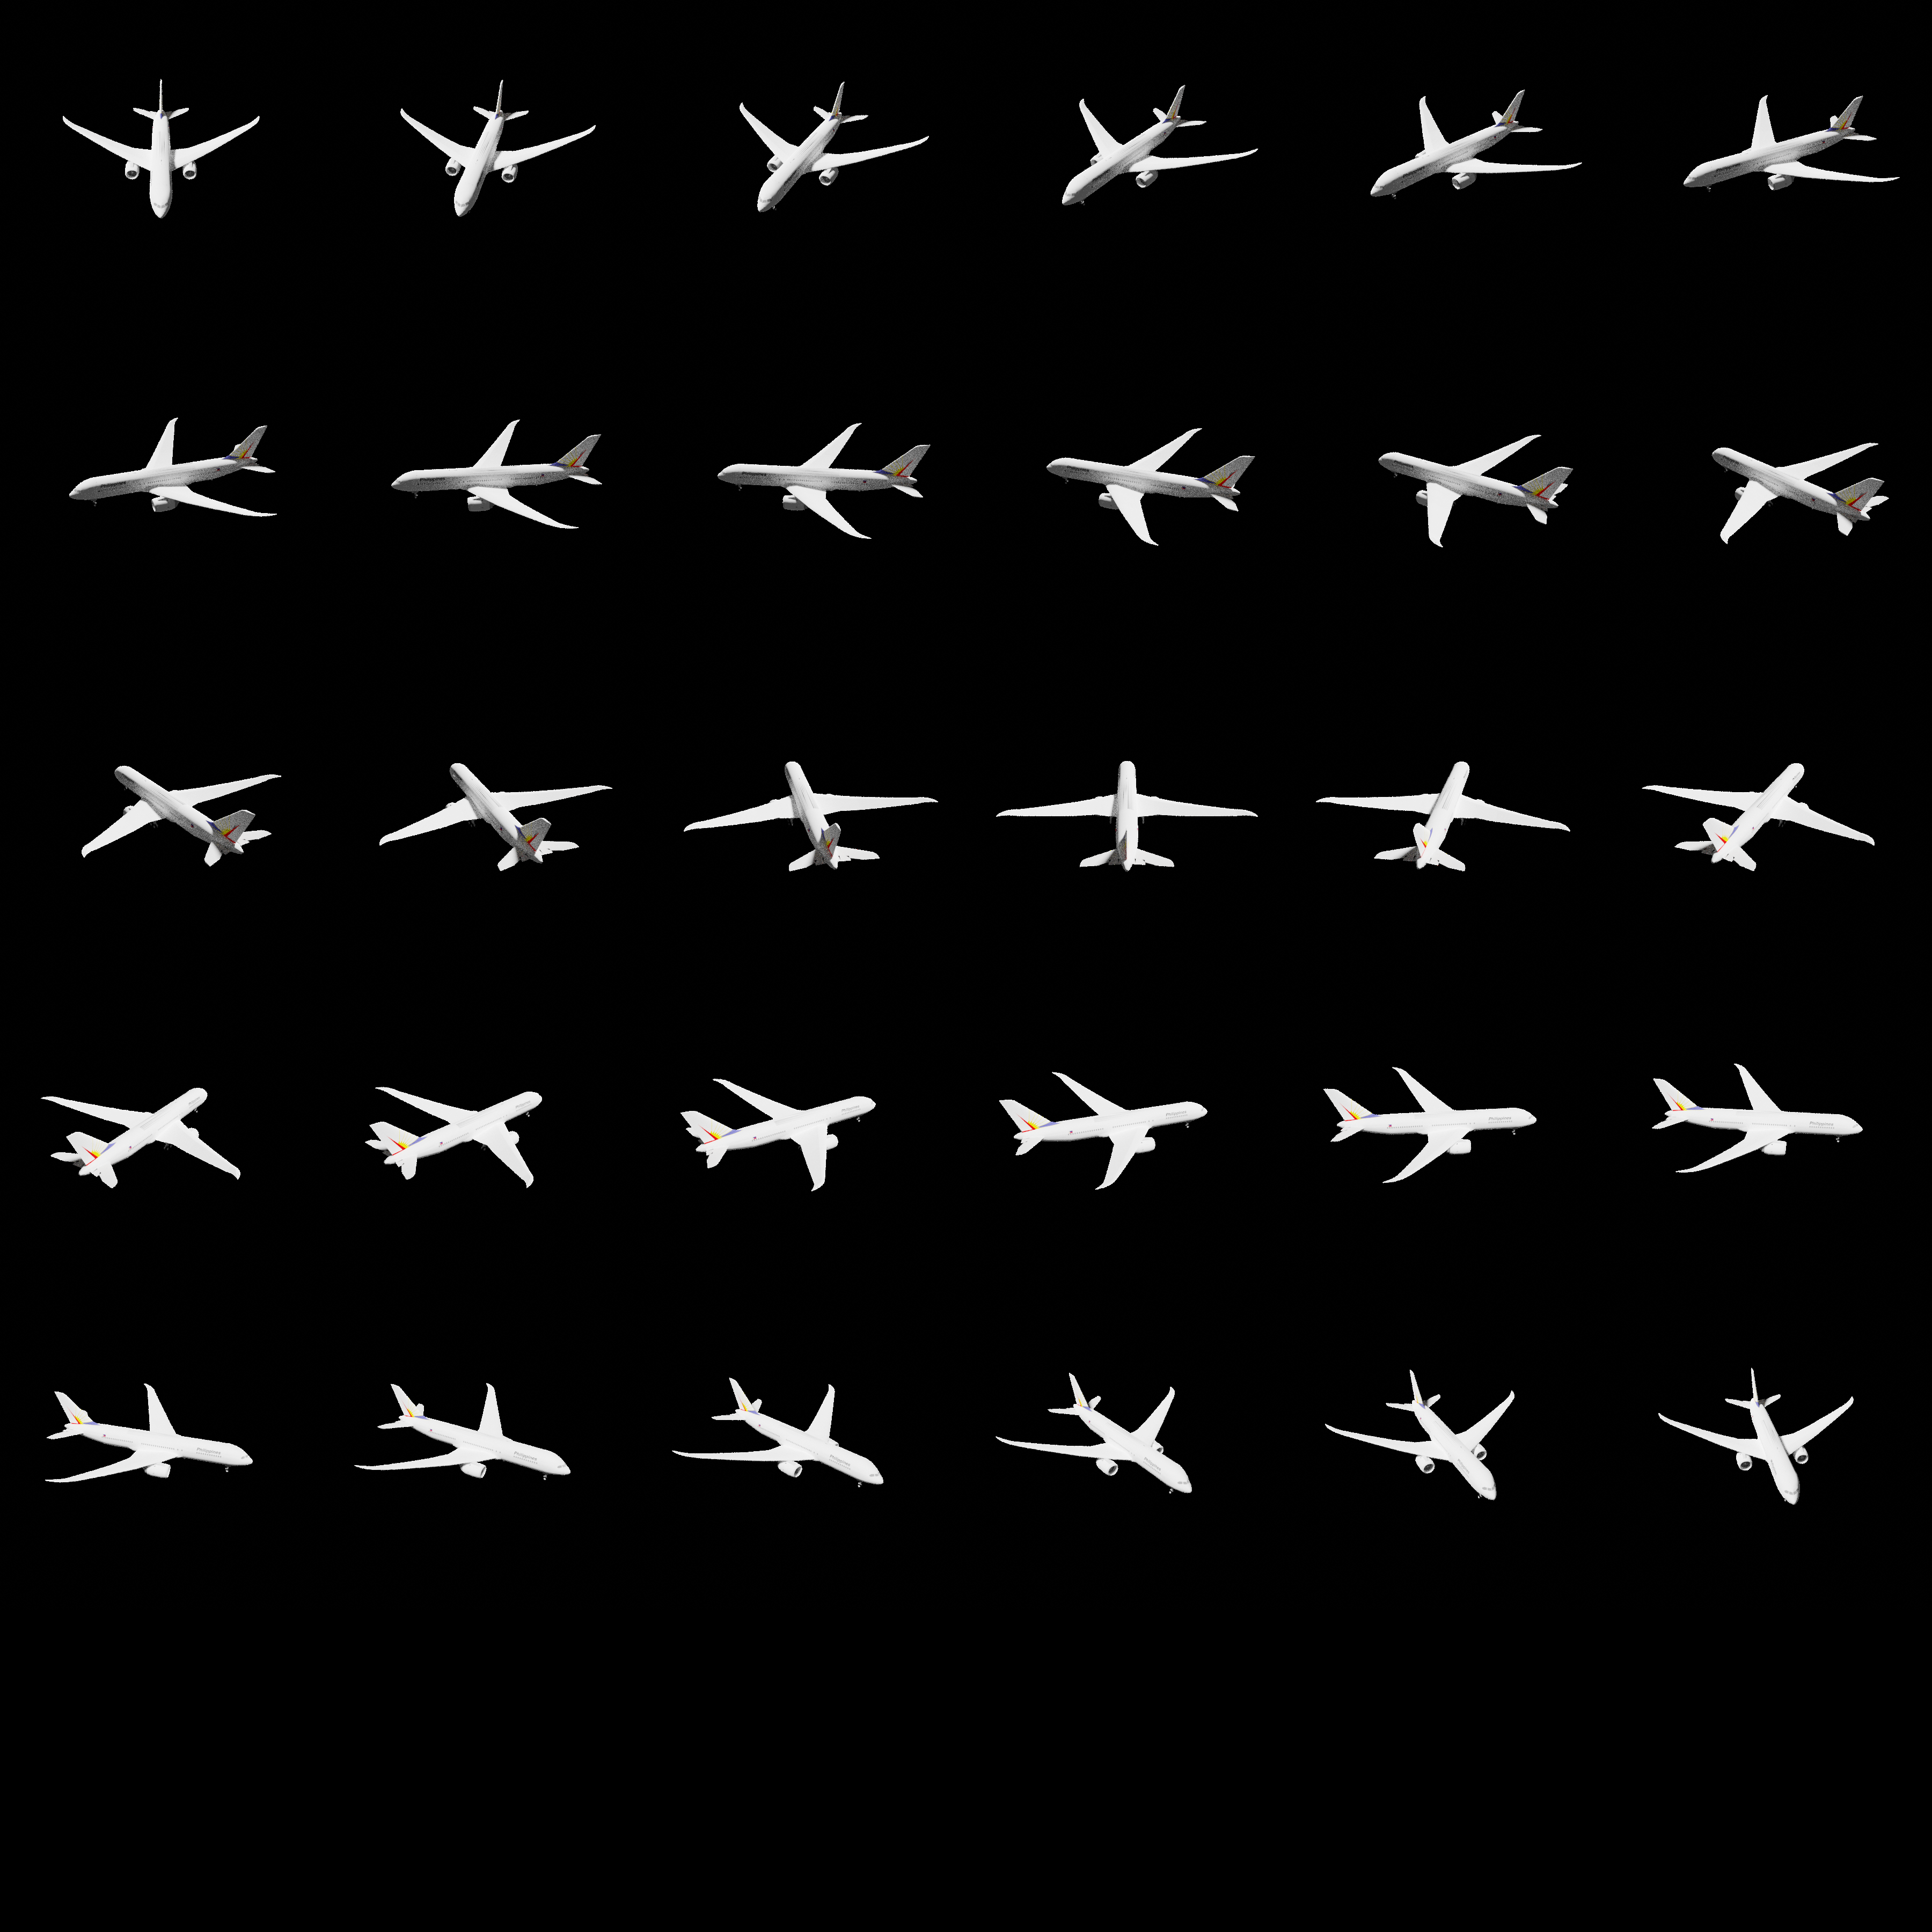

In [84]:
RGB_imgs_show

In [85]:
# print(data)

In [86]:
def choose_random_angles(data, angle_range=90):
    # 获取所有角度信息
    angles = [data[key]['angle'] for key in data if key.startswith('angle_')]

    # 随机选择角度A及其索引
    index_A = np.random.randint(len(angles))
    angle_A = angles[index_A]
    
    # 确定B的范围
    min_angle_B = (angle_A - angle_range) % 360
    max_angle_B = (angle_A + angle_range) % 360
    
    # 生成B的有效索引范围
    if min_angle_B < max_angle_B:
        valid_indices = [i for i, angle in enumerate(angles) if min_angle_B <= angle <= max_angle_B]
    else:  # 处理角度循环
        valid_indices = [i for i, angle in enumerate(angles) if angle >= min_angle_B or angle <= max_angle_B]
        
    if not valid_indices:
        return None, None

    # 从有效索引中随机选择角度B及其索引
    index_B = np.random.choice(valid_indices)
    angle_B = angles[index_B]
    
    return index_A + 1, index_B + 1

In [87]:
index_A, index_B = choose_random_angles(data, 60)

In [88]:
angle_A = data[f"angle_{index_A}"]["angle"]
image_A = data[f"angle_{index_A}"]["image"]
angle_B = data[f"angle_{index_B}"]["angle"]
image_B = data[f"angle_{index_B}"]["image"]
captions_B = data[f"angle_{index_B}"]["captions"]

In [89]:
print(angle_A)
print(angle_B)

rotation = angle_B - angle_A
if rotation < -180:
    rotation += 360
elif rotation > 180:
    rotation -= 360

print(rotation)

96
60
-36


In [90]:
merged_img = merge_images_horizontally(image_A, image_B)
merged_img

In [91]:
captions_B

['a passenger plane is in the grey sky',
 'a 3d render of a large airplane in flight',
 'a white airplane flies through a gray sky',
 'an airplane that is flying through a grey sky',
 'an airplane is flying through a gray sky',
 'an airplane is going through a gray sky',
 'an image of a 3d picture of a jet',
 'a white passenger jet airplane against a gray sky',
 'a 3d model of an airplane passing through the air',
 'a 3d airplane flying in the sky']